In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../')
import LKBMachine as dl
import LossLKB as lf
import Data as dat

%matplotlib inline

# Setup

In [2]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'
    
tf.keras.backend.set_floatx('float64')  # !! Set precision for the entire model here
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs Available: {}".format(len(GPUS)))
print("Training at precision: {}".format(tf.keras.backend.floatx()))
print("Training on device: {}".format(DEVICE))

TensorFlow version: 2.4.1
Eager execution: True
Num GPUs Available: 2
Training at precision: float64
Training on device: /GPU:0


# Load model and data

In [3]:
# SET THIS PATH (w/o file extension!). Both '.pkl' and '.h5' files should have same name
model_path = './trained_models/pendulum_2021-05-25-2300/epoch_100_loss_-2.8'
model_hyp_params = model_path + '.pkl'
model_weights = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(model_hyp_params, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load evenly spaced rings for test trajectories (from Lusch et al 2018)
rings = np.loadtxt('PendulumRings.csv', delimiter=',')
test_data = rings.reshape((rings.shape[0], int(rings.shape[1]/2), 2))
test_data = tf.cast(test_data, dtype=hyp_params['precision'])
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (10, 1500, 2)


In [4]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]
hyp_params['num_time_steps'] = test_data.shape[1]
hyp_params['latent_dim'] = test_data.shape[2]
hyp_params['phys_dim'] = test_data.shape[2]

# Load the trained DLDMD model weights
model = dl.LKBMachine(hyp_params)
model.num_pred_steps = hyp_params['num_time_steps']
model.time_final = int(hyp_params['num_time_steps'] * model.delta_t)
model(test_data)
model.load_weights(model_weights)

# Initialize the loss function
loss = lf.LossLKB(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)

Number of prediction steps:  1500


# Run the trained model

In [5]:
with tf.device(DEVICE):
    preds = model(test_data, training=False)
    losses = loss(preds, test_data)

[y, x_ae, x_adv, y_adv, weights, evals_real, evals_cmplx] = preds
print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.0006010
Log10 Loss: -3.2211544


# Visualize results

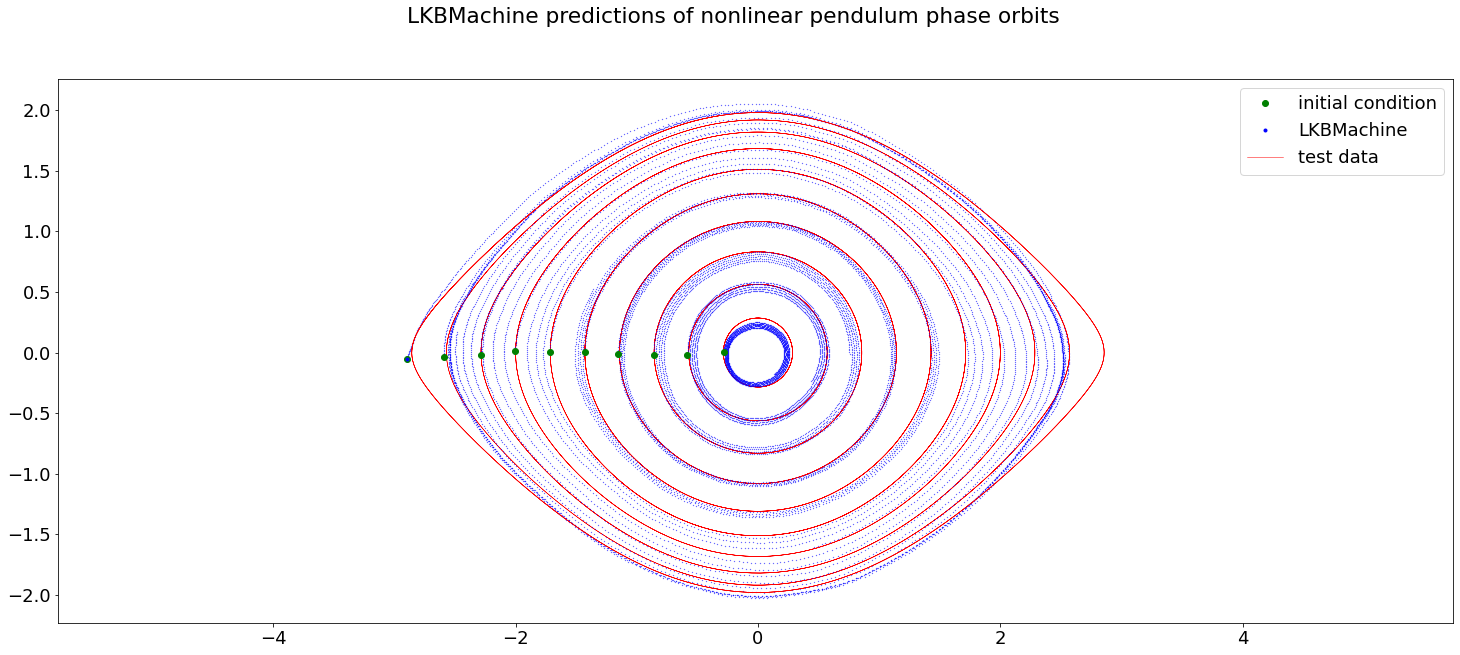

In [6]:
fig = plt.figure(3141, figsize=(25,10))
ax1 = plt.subplot(1, 1, 1)
for ii in range(test_data.shape[0]):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'r-', lw=0.5)
    ax1.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], 'b.', ms=0.5)
ax1.plot(x_adv[:, 0, 0], x_adv[:, 0, 1], 'go', label='initial condition')
ax1.plot(x_adv[0, 0, 0], x_adv[0, 0, 1], 'b.', label='LKBMachine')
ax1.plot(test_data[0, :, 0], test_data[0, :, 1], 'r-', lw=0.5, label='test data')
ax1.legend()
ax1.axis('equal')
plt.suptitle("LKBMachine predictions of nonlinear pendulum phase orbits")
plt.show()

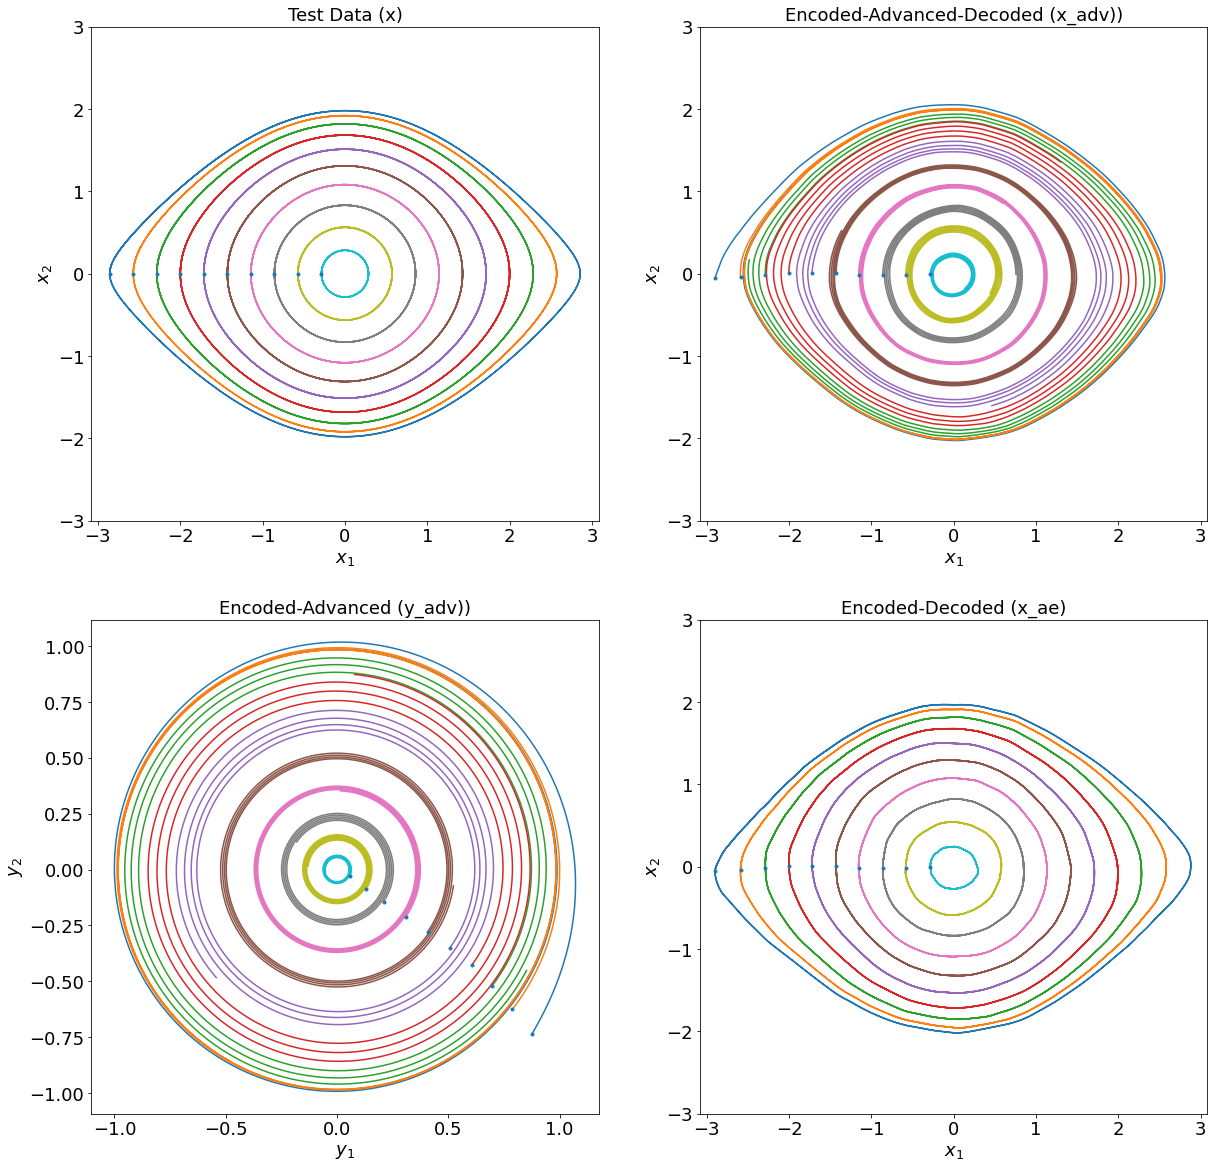

In [7]:
fig = plt.figure(1, figsize=(20,20))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
for ii in range(test_data.shape[0]):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], '-')
    ax2.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], '-')
    ax3.plot(y_adv[ii, :, 0], y_adv[ii, :, 1], '-')
    ax4.plot(x_ae[ii, :, 0], x_ae[ii, :, 1], '-')
ax1.plot(test_data[:, 0, 0], test_data[:, 0, 1], '.')
ax2.plot(x_adv[:, 0, 0], x_adv[:, 0, 1], '.')
ax3.plot(y_adv[:, 0, 0], y_adv[:, 0, 1], '.')
ax4.plot(x_ae[:, 0, 0], x_ae[:, 0, 1], '.')
ax1.axis('equal')
ax1.set_xlim([-3.1, 3.1])
ax1.set_ylim([-3.0, 3.0])
ax1.set_xlabel("$x_1$", fontsize=fontsize)
ax1.set_ylabel("$x_2$", fontsize=fontsize)
ax1.set_title("Test Data (x)", fontsize=fontsize)
ax2.axis('equal')
ax2.set_xlim([-3.1, 3.1])
ax2.set_ylim([-3.0, 3.0])
ax2.set_xlabel("$x_1$", fontsize=fontsize)
ax2.set_ylabel("$x_2$", fontsize=fontsize)
ax2.set_title("Encoded-Advanced-Decoded (x_adv))", fontsize=fontsize)
ax3.axis('equal')
ax3.set_xlabel("$y_1$", fontsize=fontsize)
ax3.set_ylabel("$y_2$", fontsize=fontsize)
ax3.set_title("Encoded-Advanced (y_adv))", fontsize=fontsize)
ax4.axis('equal')
ax4.set_xlim([-3.1, 3.1])
ax4.set_ylim([-3.0, 3.0])
ax4.set_xlabel("$x_1$", fontsize=fontsize)
ax4.set_ylabel("$x_2$", fontsize=fontsize)
ax4.set_title("Encoded-Decoded (x_ae)", fontsize=fontsize)

plt.show()